В первую очередь загрузите библиотеки. Большая часть из них – уже знакомые инструменты.

Рассмотрите подробнее **Activation** – слой, который позволяет отдельно задавать активационную функцию.

Если раньше писали `model.add(Dense(46, activation='relu'))`, то теперь можно написать `model.add(Dense(46))` и затем
`model.add(Activation('relu'))`.

Эти две записи равнозначны и работать они будут
одинаково.

In [1]:
# Библиотека работы с массивами
import numpy as np

# Библиотека для работы с таблицами
import pandas as pd

# Последовательная модель НС
from tensorflow.keras.models import Sequential

# Основные слои
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

# Слой задания активационной функции <----- !!!
from tensorflow.keras.layers import Activation

# Утилиты предобработки данных
from tensorflow.keras import utils

# Оптимизаторы
from tensorflow.keras.optimizers import Adam

# Разделение на обучающую и проверочную/тестовую выборку
from sklearn.model_selection import train_test_split

# Рисование графиков
import matplotlib.pyplot as plt

%matplotlib inline

E0000 00:00:1740946481.144064   87794 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740946481.147900   87794 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Подготовка базы

## Загрузка и просмотр содержимого


Импортируйте библиотеку `gdown`, загрузите файл **sonar.csv** из репозитория при помощи метода `.download()`:

In [2]:
import gdown

gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l4/sonar.csv', None, quiet=True)

'sonar.csv'

Прочитайте и запишите его в переменную `df`, указывая, что в таблице нет заголовка `(header=None)`, выведите размерность датафрейма при помощи метода `.shape`:

In [3]:
df = pd.read_csv("sonar.csv", header=None)

print(df.shape)

(208, 61)


Выведите первые пять строчек таблицы, чтобы понимать, с какими данными придется работать:

In [4]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


В таблице вы увидите 61 столбец:
- первые 60 описывают параметры объекта
- последний 61-й содержит класс объекта (R – скала, M – мина).

Задача в том, чтобы научить нейросеть определять по параметрам, скала это или мина. Подобные задачи относятся к типу бинарной классификации.

## Парсинг





Перед тем как приступить к выполнению задания, давайте немного подготовим базу. Так как НС не работает с буквами, переведите все значения `R` и `M` в числа с плавающей точкой `1.` и `0.` соответственно:

In [5]:
dataset = df.replace('R', 1.).replace('M', 0.).astype(float).to_numpy()

/tmp/ipykernel_87794/3864906435.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset = df.replace('R', 1.).replace('M', 0.).astype(float).to_numpy()


Почему именно 1 и 0?

Вспомните, когда мы учили нейросеть определять цифры от 0 до 9 (на основе базы MNIST), последний выходной слой содержал 10 нейронов. Первый нейрон выдавал вероятность, что изображение относится к классу 0, второй что к классу 1 и пр. Это мультиклассовая классификация.

Бинарная классификация строится подобным же образом, но чуть проще. На первый взгляд, в текущей задаче  нужен выходной слой с двумя нейронами, первый выдает вероятность, что это мина, второй что это скала. Но можно обойтись и одним, т.к. если это не скала, то точно мина, других вариантов нет.

Если сеть выдает предсказание, что полученный объект на 40% процентов мина, само собой разумеется, что это на 60% скала, так как суммарная вероятность равна 1.

В `x_data` добавьте параметры объекта, в `y_data` – класс объекта (правильные ответы).

Способ разделения - срез (вариант 1 из ноутбука по теории):


In [6]:
x_data = dataset[:, :60]
y_data = dataset[:, 60]

Проверьте форму данных и содержимое `y_data`. В выборке всего `208` примеров.

In [7]:
print('Размерность набора параметров объектов', x_data.shape)
print('Размерность набора меток класса', y_data.shape)
print()
print('Содержание y_data:', y_data)

Размерность набора параметров объектов (208, 60)
Размерность набора меток класса (208,)

Содержание y_data: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Создание обучающей и тестовой выборки


Чуть выше мы разделили весь массив данных на два набора: параметров объекта и соответствующих им меток классов. Пришло время разделить наборы на обучающую и тестовую выборки. Воспользуемся функцией `train_test_split` (см. теоретическую часть):

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x_data, # набор параметров
                                                    y_data, # набор меток классов
                                                    test_size=0.2, # процент в тестовую
                                                    shuffle=True, #  перемешивание
                                                    random_state=3) # воспроизводимость

# Выведем размерность полученных выборок

print('Обучающая выборка параметров', x_train.shape)
print('Обучающая выборка меток классов', y_train.shape)
print()
print('Тестовая выборка параметров', x_test.shape)
print('Тестовая выборка меток классов', y_test.shape)

Обучающая выборка параметров (166, 60)
Обучающая выборка меток классов (166,)

Тестовая выборка параметров (42, 60)
Тестовая выборка меток классов (42,)


# Обучение нейросети

Напишем функцию сборки необученной модели нейронной сети. Это значит, что теперь нам не придется для создания еще одной модели заново прописывать все слои, достаточно будет вызвать функцию.

Первый слой НС – полносвязный на `60` нейронов, еще один слой на `30` нейронов, и последний слой на `1` нейрон.

В выходном слое используем функцию активации `sigmoid`, т.к. она преобразует вход в число от `0` до `1`.

Скомпилируйте НС и укажите `binary_crossentropy` в качестве функции ошибки, т.к. решается задача бинарной классификации:

In [9]:
def create_model():

    # Создание модели
    model = Sequential()

    # Добавление слоев
    model.add(Dense(60, input_dim=x_train.shape[1], activation='relu'))
    model.add(Dense(30))
    model.add(Activation('relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Компиляция и возврат модели
    model.compile(loss='binary_crossentropy',
                  optimizer=Adam(learning_rate=0.001),
                  metrics=['accuracy'])

    return model

In [10]:
# Создание необученной модели при помощи функции create_model()
model = create_model()

# Обучение модели
history = model.fit(x_train,       # Обучающая выборка параметров
          y_train,       # Обучающая выборка меток класса
          batch_size=8,  # Размер батча (пакета)
          epochs=100,    # Количество эпох обучения
          verbose=1)     # Отображение хода обучения

/home/aledonio/.cache/pypoetry/virtualenvs/global-cKEoLTwX-py3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1740946933.561839   87794 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Epoch 1/100


I0000 00:00:1740946935.111580   90413 service.cc:148] XLA service 0x7f2620006790 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740946935.111638   90413 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
I0000 00:00:1740946935.251819   90413 cuda_dnn.cc:529] Loaded cuDNN version 90300


20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4838 - loss: 0.7055

I0000 00:00:1740946935.900035   90413 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.4869 - loss: 0.7046
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6055 - loss: 0.6614 
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7217 - loss: 0.6183 
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7180 - loss: 0.5985 
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7865 - loss: 0.5654 
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7842 - loss: 0.5320 
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7555 - loss: 0.4836 
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8171 - loss: 0.4642 
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8075 - loss: 0.4330 
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7774 - loss: 0.4404 
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8288 - loss: 0.3730 
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 

## Оценка качества обучения

На тренировочной выборке НС достигает точности в **100%**. Приятная глазу цифра, но, к сожалению, не отражающая истинное положение дел.

Чтобы перепроверить нейросеть, а так же выяснить научилась она выявлять закономерности, или же просто заучила данные - создадим проверочную (валидационную) выборку.

In [11]:
# Создание необученной модели при помощи функции create_model()
model = create_model()

# Обучение нейронной сети
history = model.fit(x_train,               # Обучающая выборка параметров
          y_train,               # Обучающая выборка меток класса
          batch_size=8,          # Размер батча (пакета)
          epochs=100,            # Количество эпох обучения
          validation_split=0.2,  # Доля проверочной выборки
          verbose=1)             # Отображение хода обучения

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - accuracy: 0.5266 - loss: 0.6982 - val_accuracy: 0.7353 - val_loss: 0.6600
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7050 - loss: 0.6656 - val_accuracy: 0.6471 - val_loss: 0.6641
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7619 - loss: 0.6405 - val_accuracy: 0.7353 - val_loss: 0.6264
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7041 - loss: 0.6110 - val_accuracy: 0.6765 - val_loss: 0.6152
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8035 - loss: 0.5887 - val_accuracy: 0.6471 - val_loss: 0.6193
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8125 - loss: 0.5722 - val_accuracy: 0.6765 - val_loss: 0.5991
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8541 - loss: 0.5142 - val_accuracy: 0.6176 - val_loss: 0.6185
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7982 - loss: 0.5226 - val_accuracy: 0.7059 -

При запуске ячейки можно увидеть, что параметры процесса обучения изменились: добавилась информация о результатах предсказаний на проверочной выборке. Точность на проверочной выборке – **85%**.



Как теперь проходит обучение? После того, как НС прошла первую эпоху, вычислила ошибку и веса нейронов изменились, модель прогоняется на проверочной выборке и предсказывает результаты. На проверочной выборке НС не обучается. Затем начинается следующая эпоха обучения и процесс повторяется.

Применим метод `.evaluate()` к нашей модели, в качестве параметров передадим ему тестовые выборки и согласие на отображение хода вычисления. Поместим результат в переменную `scores`:

In [12]:
scores = model.evaluate(x_test,
                        y_test,
                        verbose=1
                        )

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 321ms/step - accuracy: 0.8631 - loss: 0.3278


In [13]:
print('Процент верных ответов на тестовых данных:', round(scores[1],2) * 100, '%')

Процент верных ответов на тестовых данных: 86.0 %


**Выводы:**

- `Точность на обучающей выборке` имеет самую низкую важность. Поскольку модели НС при обучении предъявляются и входные данные, и правильные ответы к ним, она может их просто зазубрить.

- `Точность на проверочной` важнее, так как её сеть видит только после окончания эпохи обучения и использует для проверки.

- `Точность на тестовой выборке` самая важная, так как она в процессе обучения в принципе не предъявляется модели.

## Визуализация качества обучения


Обучите НС, при этом результаты процесса обучения запишите в переменную **history**:

In [14]:
# Создание модели
model = create_model()

# Обучение нейронной сети
history = model.fit(x_train,
                    y_train,
                    batch_size=8,
                    epochs=100,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.4748 - loss: 0.6905 - val_accuracy: 0.6765 - val_loss: 0.6501
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6431 - loss: 0.6595 - val_accuracy: 0.7059 - val_loss: 0.6424
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7562 - loss: 0.6316 - val_accuracy: 0.7647 - val_loss: 0.6326
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6783 - loss: 0.6223 - val_accuracy: 0.7647 - val_loss: 0.6149
Epoch 5/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7844 - loss: 0.5958 - val_accuracy: 0.7647 - val_loss: 0.5974
Epoch 6/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7276 - loss: 0.5842 - val_accuracy: 0.7647 - val_loss: 0.5864
Epoch 7/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7626 - loss: 0.5763 - val_accuracy: 0.7059 - val_loss: 0.5908
Epoch 8/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7488 - loss: 0.5225 - val_accuracy: 0.7353 - 

Постройте график точности на протяжении всего обучения.

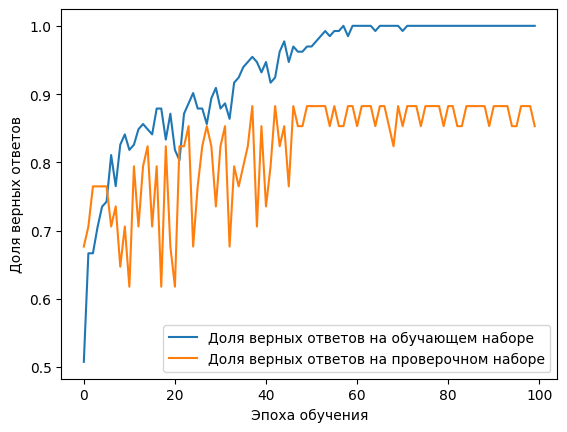

In [15]:
# Визуализация точности на обучающей выборке

plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')

# Визуализация точности на проверочной выборке
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')

# Отрисовка подписей осей
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')

# Отрисовка легенды
plt.legend()

# Вывод графика
plt.show()

На картинке можно видеть, что на последних эпохах точность на обучающей выборке достигла **100%**.

Также видно, что примерно на **30** эпохе обучения точность распознавания на проверочном наборе приблизилась к **85%**.

Теперь выведите график ошибки:

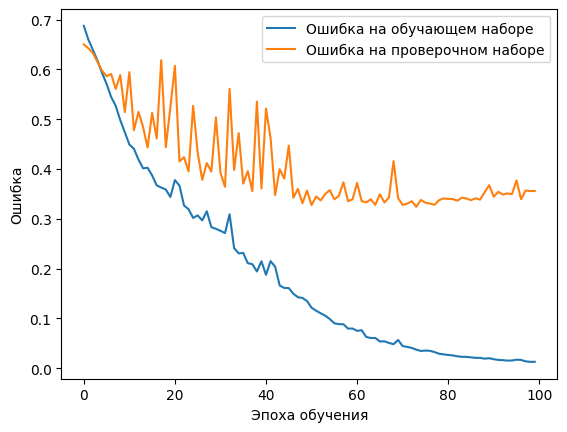

In [16]:
plt.plot(history.history['loss'],
         label='Ошибка на обучающем наборе')

plt.plot(history.history['val_loss'],
         label='Ошибка на проверочном наборе')

plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')

plt.legend()

plt.show()

Последний график имеет большое значение для нейронщика. Если ошибка на обучающей выборке стремится к **0**, а на проверочной выборке снижается, но потом снова растет – это эффект переобучения. Примерно после **30** эпохи НС начинает заучивать ответы.

## Что делать с переобучением?

Попробуем решить проблему переобучения в исследуемой задаче.

### Слой  Dropout

Возьмите исходную архитектуру НС и добавьте слои `Dropout` (см. теоретическая часть):

In [17]:
# Создание последовательной модели
model = Sequential()
model.add(Dropout(0.3, input_shape=(x_train.shape[1],)))
model.add(Dense(60, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(30, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

# Компиляция модели
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Обучение сети
history = model.fit(x_train,
                    y_train,
                    batch_size=8,
                    epochs=200,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/200


/home/aledonio/.cache/pypoetry/virtualenvs/global-cKEoLTwX-py3.12/lib/python3.12/site-packages/keras/src/layers/regularization/dropout.py:42: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.4658 - loss: 0.7196 - val_accuracy: 0.6471 - val_loss: 0.6788
Epoch 2/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4641 - loss: 0.7125 - val_accuracy: 0.3824 - val_loss: 0.7188
Epoch 3/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4765 - loss: 0.6813 - val_accuracy: 0.3529 - val_loss: 0.7207
Epoch 4/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5294 - loss: 0.6884 - val_accuracy: 0.5294 - val_loss: 0.6921
Epoch 5/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4952 - loss: 0.7060 - val_accuracy: 0.5000 - val_loss: 0.6942
Epoch 6/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5945 - loss: 0.6725 - val_accuracy: 0.4118 - val_loss: 0.6976
Epoch 7/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6578 - loss: 0.6395 - val_accuracy: 0.6176 - val_loss: 0.6790
Epoch 8/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5651 - loss: 0.6732 - val_accuracy: 0.5882 - val_loss: 0

Результаты показывают, что даже после **200** эпох точность на обучающей выборке
остановилось на **85%**. Переобучения нет.

In [18]:
# Краткая сводка архитектуры модели
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 60)             │         3,660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 30)             │         1,830 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,565 (64.71 KB)

 Trainable params: 5,521 (21.57 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,044 (43.14 KB)

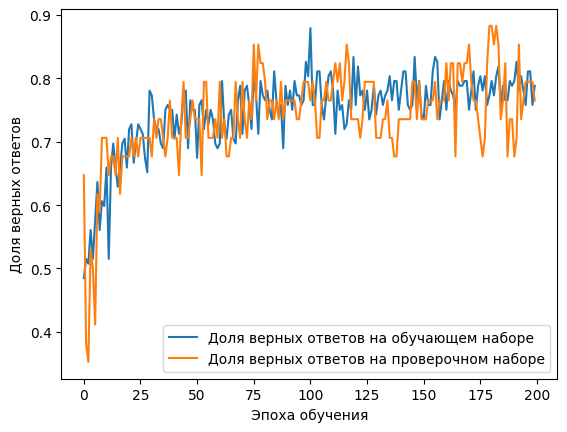

In [19]:
# Отрисовка графика точности на обучающей выборке
# label - имя графика в легенде
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')

# Отрисовка графика точности на проверочной выборке
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')

# Отрисовка подписей осей
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')

# Отрисовка легенду
plt.legend()

# Вывод графика
plt.show()

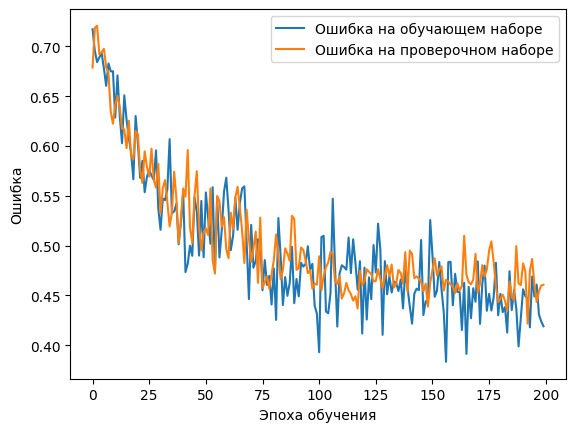

In [20]:
# Вывод графика ошибки
plt.plot(history.history['loss'],
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

Оба графика подтверждают, что переобучения больше нет.

In [21]:
# Вычисление результата (предсказания) сети на тестовом наборе
scores = model.evaluate(x_test, y_test, verbose=1)

print(scores)
print('Доля верных ответов на тестовых данных, в процентах: {:7.4%}'.format(scores[1]))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.8686 - loss: 0.3914
[0.38645291328430176, 0.8809523582458496]
Доля верных ответов на тестовых данных, в процентах: 88.0952%


Теперь проверка НС на тестовом наборе показала, что точность выросла почти на **4%** и приблизилась к отметке в **90%**.

### Слой BatchNormalization


Epoch 1/100


/home/aledonio/.cache/pypoetry/virtualenvs/global-cKEoLTwX-py3.12/lib/python3.12/site-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5682 - loss: 0.8554 - val_accuracy: 0.2941 - val_loss: 0.7814
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5758 - loss: 0.7907 - val_accuracy: 0.2941 - val_loss: 0.7699
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.6061 - loss: 0.7323 - val_accuracy: 0.2941 - val_loss: 0.7591
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6212 - loss: 0.6799 - val_accuracy: 0.2941 - val_loss: 0.7486
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.6742 - loss: 0.6327 - val_accuracy: 0.3235 - val_loss: 0.7383
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.6818 - loss: 0.5892 - val_accuracy: 0.3235 - val_loss: 0.7284
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.7121 - loss: 0.5496 - val_accuracy: 0.3529 - val_loss: 0.7188
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.7348 - loss: 0.5140 - val_accuracy: 0.4118 - val_loss: 0.7098
Epoch 

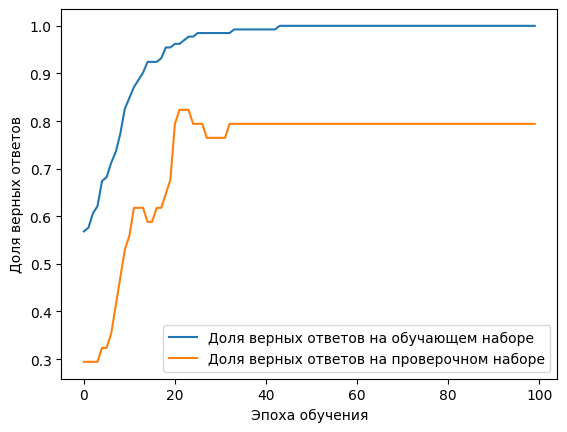

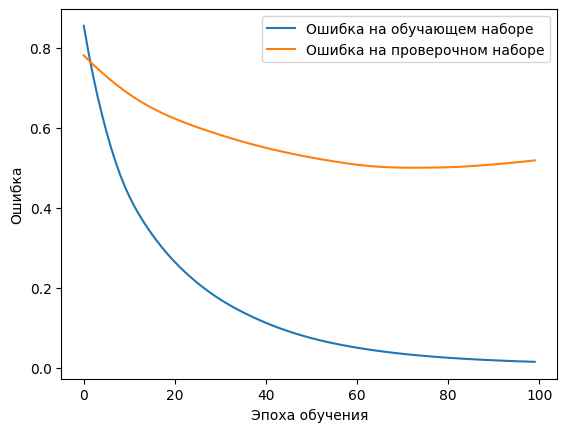

In [22]:
model = Sequential()

model.add(BatchNormalization(input_shape=(x_train.shape[1], )))
model.add(Dense(60, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(30, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

history = model.fit(x_train,
                    y_train,
                    batch_size=200,
                    epochs=100,
                    validation_split=0.2,
                    verbose=1)

plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

plt.plot(history.history['loss'],
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

Как видите, результата почти никакого.

При этом на тестовой выборке результат очень сильно ухудшился. Возможно, стоит изменить архитектуру модели.

In [23]:
# Вычисление результата (предсказания) сети на тестовом наборе

scores = model.evaluate(x_test, y_test, verbose=1)

print(scores)
print('Доля верных ответов на тестовых данных, в процентах: {:7.4%}'.format(scores[1]))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.5526 - loss: 0.8406
[0.8584700226783752, 0.5476190447807312]
Доля верных ответов на тестовых данных, в процентах: 54.7619%


### Совмещение Dropout и BatchNormalization

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5758 - loss: 0.7799 - val_accuracy: 0.6765 - val_loss: 0.6550
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.5152 - loss: 0.8507 - val_accuracy: 0.7059 - val_loss: 0.6498
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6439 - loss: 0.7957 - val_accuracy: 0.7059 - val_loss: 0.6449
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5909 - loss: 0.7482 - val_accuracy: 0.7059 - val_loss: 0.6402
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.6364 - loss: 0.6656 - val_accuracy: 0.7059 - val_loss: 0.6361
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.7273 - loss: 0.6097 - val_accuracy: 0.7059 - val_loss: 0.6326
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.6818 - loss: 0.6469 - val_accuracy: 0.7059 - val_loss: 0.6289
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.6288 - loss: 0.6743 - val_accuracy: 0.7059 - val_loss: 0

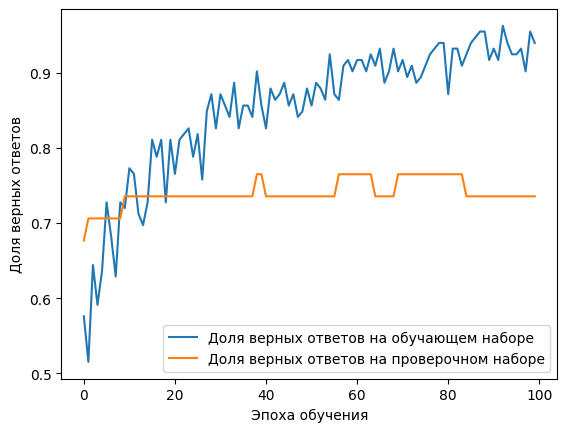

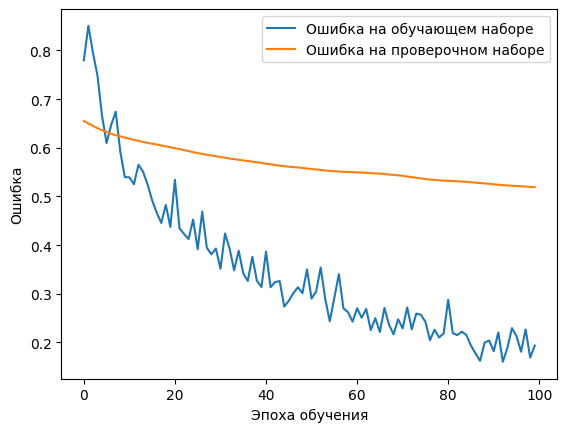

In [24]:
model = Sequential()

model.add(Dense(60, activation='relu', input_shape=(x_train.shape[1], )))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(30, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

history = model.fit(x_train,
                    y_train,
                    batch_size=200,
                    epochs=100,
                    validation_split=0.2,
                    verbose=1)

plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

plt.plot(history.history['loss'],
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

In [25]:
# Вычисление результата (предсказания) сети на тестовом наборе

scores = model.evaluate(x_test, y_test, verbose=1)

print(scores)
print('Доля верных ответов на тестовых данных, в процентах: {:7.4%}'.format(scores[1]))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.6473 - loss: 0.5583
[0.559333086013794, 0.6428571343421936]
Доля верных ответов на тестовых данных, в процентах: 64.2857%


Это не дало лучшего результата. Можно сделать вывод, что для изучаемых данных батч-нормализация больше вредна, чем полезна.

В этом и заключается работа нейронщика: подбирать необходимую архитектуру и проводить множество экспериментов для достижения наилучшего результата.

**Содержание**:

1. [Теория](https://colab.research.google.com/drive/1C7fIw4owXEU7sMENvK6q45-BYLoWGjaT?usp=sharing)
2. Практический ноутбук